<a href="https://colab.research.google.com/github/pullz6/ADS1-Visualisation/blob/main/Aircraft_Turbo_Defect_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
pip install img2vec_pytorch

In [42]:
import pandas as pd
from img2vec_pytorch import Img2Vec
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Adding the images in.

In [43]:
train_data = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/train',labels=None,image_size=(64,64),batch_size=32,color_mode='grayscale')
test_data = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/val',labels=None,image_size=(64,64), batch_size=32,color_mode='grayscale')

Found 257 files belonging to 1 classes.
Found 73 files belonging to 1 classes.


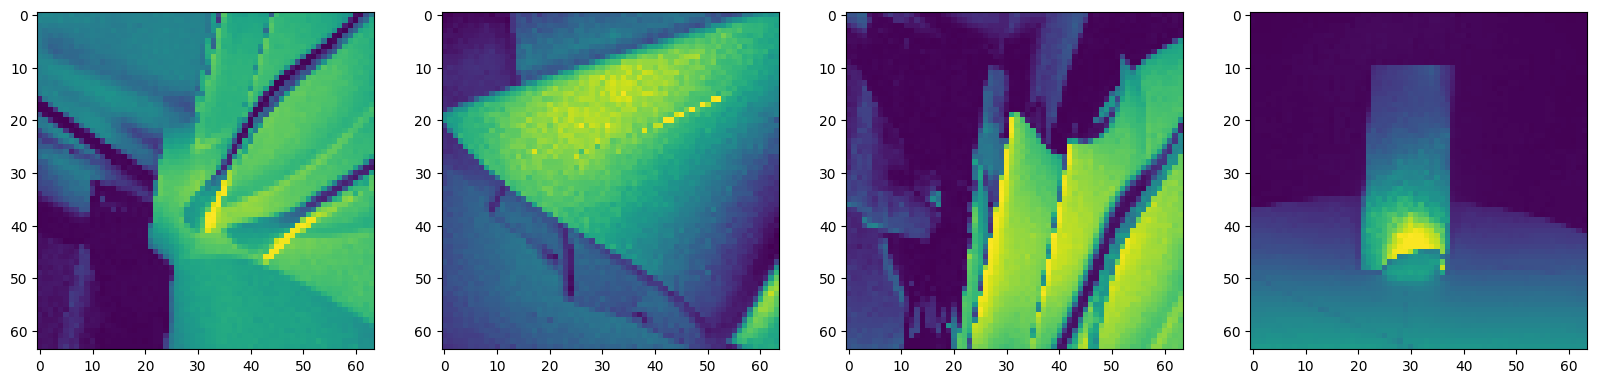

In [44]:
train_data_iterator = train_data.as_numpy_iterator()
batch = train_data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[:4]):
    ax[idx].imshow(img.astype(int))

In [45]:
name_train = os.listdir('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/train')
name_val = os.listdir('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/val')

print("Names of the train images:", name_train)
print("Names of the validation images:", name_val)

Names of the train images: ['11_flip.jpg', '12.jpg', '12_3.jpg', '13_rot2.jpg', '12_rot3.jpg', '11_1.jpg', '10.jpg', '13.jpg', '12_1.jpg', '13_1.jpg', '13_rot1.jpg', '11_rot1.jpg', '13_2.jpg', '11_rot3.jpg', '13_4.jpg', '13_3.jpg', '10_rot1.jpg', '12_flip0.jpg', '12_rot2.jpg', '13_flip1.jpg', '12_2.jpg', '11_flip1.jpg', '11_2.jpg', '12_flip1.jpg', '1.jpg', '10_flip0.jpg', '11_flip0.jpg', '10_flip.jpg', '12_rot1.jpg', '13_rot3.jpg', '10_rot2.jpg', '13_flip.jpg', '13_flip0.jpg', '10_1.jpg', '12_flip.jpg', '11_rot2.jpg', '10_flip1.jpg', '10_rot3.jpg', '11.jpg', '15_2.jpg', '16_flip.jpg', '17_1.jpg', '18_rot2.jpg', '14.jpg', '18_flip0.jpg', '16_rot3.jpg', '16_rot1.jpg', '14_flip.jpg', '18_flip1.jpg', '15_1.jpg', '16_flip0.jpg', '18_2.jpg', '15_3.jpg', '14_rot1.jpg', '17.jpg', '14_flip1.jpg', '15_rot3.jpg', '17_rot2.jpg', '14_flip0.jpg', '17_4.jpg', '18_1.jpg', '14_rot3.jpg', '16.jpg', '15_flip.jpg', '17_3.jpg', '15_rot2.jpg', '15.jpg', '17_flip1.jpg', '17_flip0.jpg', '16_rot2.jpg', '17_rot

Reading the category and the location of the data in the labels file

In [46]:
# Folder Path
path_train = "/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/labels/train"
label_train = os.listdir('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/labels/train')
label_val = os.listdir('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/labels/val')
images = []
defect_type = []
x1 = []
y1 = []
x2 = []
y2 = []
for name in label_train:
  images.append(name)
  text_file = open('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/labels/train/'+name,'r')
  t=t+1
  line_list = text_file.readlines();
  #for each line from the list, print the line
  t = 0
  for line in line_list:
    #Read the values, which comes as a string, segregate it by the space and create a list

    #In case there are two lines, we need to include the name twice in the opposing list, if not the lists lengths will be unequal.
    if t!=0:
      images.append(name)

    #Divide the strings by the space
    values = line.split(" ")

    #Add the values into lists
    defect_type.append(values[0])
    x1.append(values[1])
    y1.append(values[2])
    x2.append(values[3])
    y2.append(values[4])

    t = t+1

#don't forget to close the file
  text_file.close()

Data Cleaning and Preparation

In [47]:
#Making sure all the lengths are the same
print(len(images),len(defect_type),len(x1),len(y1),len(x2),len(y2))

379 379 379 379 379 379


In [48]:
#Creating the dataframe with all the data
df = pd.DataFrame(columns = ['Image','Defect_Type','x1','y1','x2','y2'])
df.Image = images
df.Defect_Type = defect_type
df.x1 = x1
df.x2 = x2
df.y1 = y1
df.y2 = y2
df.y2 = df["y2"].str.replace('\n','')
df.head()

,Image,Defect_Type,x1,y1,x2,y2
0,3.txt,0,0.336091,0.492765,0.243873,0.245177
1,3.txt,0,0.559589,0.510852,0.279105,0.405145
2,7_rot2.txt,0,0.376685,0.521302,0.312806,0.060289
3,7_rot2.txt,2,0.897978,0.271905,0.031250,0.069534
4,4_rot3.txt,0,0.640876,0.554075,0.388666,0.174326


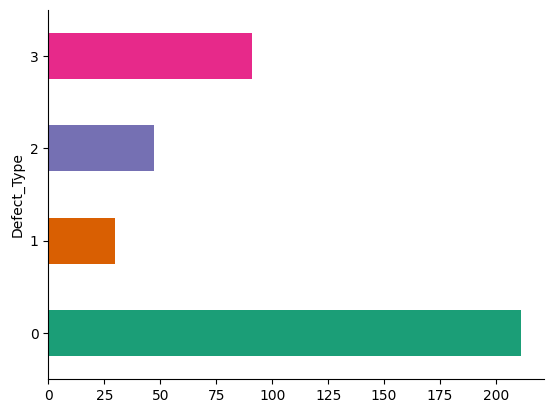

In [50]:
#Checking to see which defects are common
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Defect_Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [62]:
def return_sorted_defects (x):
  """This function takes the numerical value of a defect and returns a list of images that has that defect"""
  df_filtered = df[df['Defect_Type']==str(x)]
  image_file = df_filtered['Image'].str.replace('.txt','.jpg')
  image_file = list( dict.fromkeys(image_file))
  return image_file

#Having seperate lists per defect
images_0 = return_sorted_defects(0)
images_1 = return_sorted_defects(1)
images_2 = return_sorted_defects(2)
images_3 = return_sorted_defects(3)

<ipython-input-62-6102d7d3c994>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  image_file = df_filtered['Image'].str.replace('.txt','.jpg')


The below creates a seperate file organisation for each of the defects, this is only to run once.

In [64]:
from functools import partial

root_directory = '/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/train'

list = ('Scratch', 'Dot', 'Crease','Damage')

concat_root_path = partial(os.path.join, root_directory)
make_directory = partial(os.makedirs, exist_ok=True)

for path_items in map(concat_root_path, list):
    make_directory(path_items)

Re-organising and shifting images into the respective defect folder that was created above.

In [77]:
import shutil
def move_items(list_items, defect):
    not_in = []
    """Move the images back into the new location"""
    try:
      for file in list_items:
        src_path = "/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/train/"+file
        new_path = "/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/train/"+defect+"/"+file
        shutil.move(src_path, new_path)
    except:
        print(file+ " No added")
        not_in.append(file)



move_items(images_0, "Scratch")
move_items(images_1,"Dot")
move_items(images_2,"Crease")
move_items(images_3,"Damage")

3.jpg No added
2023-04-06 19-30-33-675.jpg No added
7_rot2.jpg No added
14_rot3.jpg No added
